# Section 3_1 MLP networks


## General nn modules

In [1]:
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils.supervised_dataset import supervised_dataset as dataset
from torch.utils.data import DataLoader
from utils.transforms import flattening_transform, reshape_transform, reindex_transform, create_cell_ind_to_grid, create_flattening_index_set,channeled_flattening_transform



class resblock(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer

    def forward(self, x):
        z = self.layer(x)
        return z+x



## Global MLP datasets and training loops

In [2]:

def train_loop(dataloader, nn, optimizer, loss_fn):
    num_batches = len(dataloader)
    nn.train()
    train_loss = 0.0
    for batch, (x, t) in enumerate(dataloader):
        y_pred = nn(x)

        loss = loss_fn(y_pred,t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= num_batches
    print(f"Train loss: {train_loss:>7f}")
    return(train_loss)

def test_loop(dataloader, nn, loss_fn):
    nn.eval()
    num_batches = len(dataloader)
    test_loss = 0.0

    with torch.no_grad():
        for x, t in dataloader:
            y_pred = nn(x)

            loss = loss_fn(y_pred,t)

            test_loss += loss.item()

    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")
    return(test_loss)


def train(
        device,
        nn,
        step_size,
        epochs, 
        train_set_input_dir,
        train_set_target_dir,
        test_set_input_dir,
        test_set_target_dir,
        batch_size,
        save_steps = 10,
        train_loss_file = None, 
        test_loss_file = None,
        model_dir = None,
        figure = None,
        figure_file = None,
        conv_type=2,
):
    H,W = 32,32
    if conv_type == 0:
        target_transform = flattening_transform(torch.arange(H*W), 1, True)
        transform = flattening_transform(create_flattening_index_set(H+2,W+2,False),13, True)
    if conv_type == 1:
        target_transform = flattening_transform(torch.arange(H*W), 1, True)
        transform = channeled_flattening_transform(create_flattening_index_set(H+2,W+2,False),13)
    if conv_type == 2:
        target_transform = reshape_transform(H,W)
        transform = None

    train_set = dataset(
        input_dir=train_set_input_dir, 
        target_dir=train_set_target_dir, 
        transform=transform, 
        target_transform=target_transform, 
        device=device
    )

    test_set = dataset(
        input_dir=test_set_input_dir, 
        target_dir=test_set_target_dir, 
        transform=transform, 
        target_transform=target_transform, 
        device=device
    )
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    
    model = nn
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size)
    train_loss_array = np.array([])
    test_loss_array = np.array([])
    loss_fn = torch.nn.MSELoss()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss_array = np.append(
            train_loss_array, 
            train_loop(
                dataloader=train_loader,
                nn=model,
                optimizer=optimizer,
                loss_fn=loss_fn
                )
        )
        scheduler.step()
        if model_dir and (t+1)%save_steps==0:
            torch.save(nn.state_dict(), f'{model_dir}_{t}.pth')
        test_loss_array = np.append(
            test_loss_array,
            test_loop(
                dataloader=test_loader, 
                nn=model, 
                loss_fn=loss_fn
            )
        )
    if train_loss_file:
        np.save(file=train_loss_file, arr=train_loss_array)
    if test_loss_file:
        np.save(file=test_loss_file, arr=test_loss_array)
    if figure:
        clear_output()
        x= np.linspace(1,len(train_loss_array),len(train_loss_array))

        plt.plot(x, train_loss_array, label= 'Train loss', linestyle='-',)
        plt.plot(x, test_loss_array,label='Test loss', linestyle='-')

        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.grid(True)
        if figure_file:
            plt.savefig(figure_file)
        plt.show()
    return train_loss_array, test_loss_array

## Different network configurations

4 Convolutional layer with kernel size (3,3) for 2d and 9 for 1d. channelsizes: 13 -> 9 -> 5 -> 3 -> 1.

In [ ]:
from utils.transforms import cells_from_flat_array_ind
class cnn1d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=13,out_channels=9,kernel_size=9, padding=4,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=9,out_channels=5,kernel_size=9, padding=4,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=5,out_channels=3,kernel_size=9, padding=4,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=3,out_channels=1,kernel_size=9, padding=4,dtype=torch.float32, device='mps')
        )
        self.idx_key = cells_from_flat_array_ind(34,34)

    def forward(self, x):
        z = self.net(x)
        return z[:,:,self.idx_key]

model1d=cnn1d()
train(
    device='mps',
    nn=model1d,
    step_size=10,
    epochs=40,
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size=10,
    save_steps=1,
    train_loss_file="data/example_3_2/train_loss_cnn_1d",
    test_loss_file="data/example_3_2/test_loss_cnn_1d",
    model_dir="data/example_3_2/models/cnn_1d",
    figure=None,
    figure_file=None,
    conv_type=1
)

class cnn2d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=13,out_channels=9,kernel_size=3, padding=1,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=9,out_channels=5,kernel_size=3, padding=1,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=5,out_channels=3,kernel_size=3, padding=1,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=3,out_channels=1,kernel_size=3, padding=0,dtype=torch.float32, device='mps')
        )

    def forward(self, x):
        z = self.net(x)
        return z

model2d=cnn2d()

train(
    device='mps',
    nn=model2d,
    step_size=10,
    epochs=40,
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size=10,
    save_steps=1,
    train_loss_file="data/example_3_2/train_loss_cnn_2d",
    test_loss_file="data/example_3_2/test_loss_cnn_2d",
    model_dir="data/example_3_2/models/cnn_2d",
    figure=None,
    figure_file=None,
    conv_type=2
)

3 Convolutional layers with kernel size (3,3) and 9 with channelsizes 13 -> 5 -> 3 ->1.

In [ ]:
from utils.transforms import cells_from_flat_array_ind
class cnn1d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=13,out_channels=5,kernel_size=9, padding=4,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=5,out_channels=3,kernel_size=9, padding=4,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=3,out_channels=1,kernel_size=9, padding=4,dtype=torch.float32, device='mps')
        )
        self.idx_key = cells_from_flat_array_ind(34,34)

    def forward(self, x):
        z = self.net(x)
        return z[:,:,self.idx_key]

model1d=cnn1d()


train(
    device='mps',
    nn=model1d,
    step_size=10,
    epochs=40,
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size=10,
    save_steps=1,
    train_loss_file="data/example_3_2/train_loss_cnn_1d_3layers",
    test_loss_file="data/example_3_2/test_loss_cnn_1d_3layers",
    model_dir="data/example_3_2/models/cnn_1d_3layers",
    figure=None,
    figure_file=None,
    conv_type=1
)

class cnn2d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=13,out_channels=5,kernel_size=3, padding=1,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=5,out_channels=3,kernel_size=3, padding=1,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=3,out_channels=1,kernel_size=3, padding=0,dtype=torch.float32, device='mps')
        )

    def forward(self, x):
        z = self.net(x)
        return z

model2d=cnn2d()

train(
    device='mps',
    nn=model2d,
    step_size=10,
    epochs=40,
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size=10,
    save_steps=1,
    train_loss_file="data/example_3_2/train_loss_cnn_2d_3layers",
    test_loss_file="data/example_3_2/test_loss_cnn_2d_3layers",
    model_dir="data/example_3_2/models/cnn_2d_3layers",
    figure=None,
    figure_file=None,
    conv_type=2
)

## Visualization of the loss values

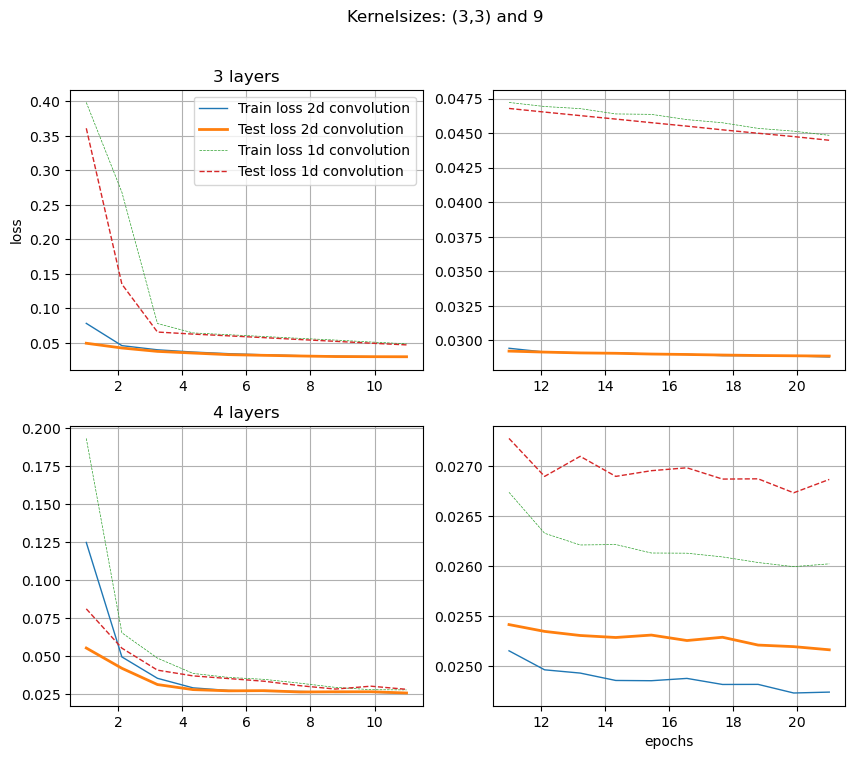

In [55]:
start = 0
end = 10
start1 = 10
end1 = 20

flat_train = np.load('data/example_3_2/train_loss_cnn_1d.npy')
flat_test = np.load('data/example_3_2/test_loss_cnn_1d.npy')
img_train = np.load('data/example_3_2/train_loss_cnn_2d.npy')
img_test = np.load('data/example_3_2/test_loss_cnn_2d.npy')

flat_train_3l = np.load('data/example_3_2/train_loss_cnn_1d_3layers.npy')
flat_test_3l = np.load('data/example_3_2/test_loss_cnn_1d_3layers.npy')
img_train_3l = np.load('data/example_3_2/train_loss_cnn_2d_3layers.npy')
img_test_3l = np.load('data/example_3_2/test_loss_cnn_2d_3layers.npy')

x= np.linspace(start+1,end+1,len(img_train[start:end]))#
x1 = np.linspace(start1+1,end1+1, len(img_train[start+1:end+1]))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=False, sharex=False)

ax1.plot(x, img_train_3l[start:end],label='Train loss 2d convolution', linestyle='-', linewidth=1)
ax1.plot(x, img_test_3l[start:end],label='Test loss 2d convolution', linestyle='-', linewidth=2)
ax1.plot(x, flat_train_3l[start:end],label='Train loss 1d convolution', linestyle='--', linewidth=0.5)
ax1.plot(x, flat_test_3l[start:end],label='Test loss 1d convolution', linestyle='--', linewidth=1)

ax2.plot(x1, img_train_3l[start1:end1],label='Train loss 2d convolution', linestyle='-', linewidth=1)
ax2.plot(x1, img_test_3l[start1:end1],label='Test loss 2d convolution', linestyle='-', linewidth=2)
ax2.plot(x1, flat_train_3l[start1:end1],label='Train loss 1d convolution', linestyle='--', linewidth=0.5)
ax2.plot(x1, flat_test_3l[start1:end1],label='Test loss 1d convolution', linestyle='--', linewidth=1)

ax3.plot(x, img_train[start:end],label='Train loss 2d convolution', linestyle='-', linewidth=1)
ax3.plot(x, img_test[start:end],label='Test loss 2d convolution', linestyle='-', linewidth=2)
ax3.plot(x, flat_train[start:end],label='Train loss 1d convolution', linestyle='--', linewidth=0.5)
ax3.plot(x, flat_test[start:end],label='Test loss 1d convolution', linestyle='--', linewidth=1)

ax4.plot(x1, img_train[start1:end1],label='Train loss 2d convolution', linestyle='-', linewidth=1)
ax4.plot(x1, img_test[start1:end1],label='Test loss 2d convolution', linestyle='-', linewidth=2)
ax4.plot(x1, flat_train[start1:end1],label='Train loss 1d convolution', linestyle='--', linewidth=0.5)
ax4.plot(x1, flat_test[start1:end1],label='Test loss 1d convolution', linestyle='--', linewidth=1)

fig.suptitle('Kernelsizes: (3,3) and 9')
fig.set_size_inches(10,8)
ax4.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_title('3 layers')
ax3.set_title('4 layers')
ax1.legend()
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)
plt.savefig('example_3_2_loss_values.png')
plt.show()

3 Convolutional layers with kernel size (5,5) and 25 with channelsizes 13 -> 5 -> 3 ->1.

In [ ]:
from utils.transforms import cells_from_flat_array_ind
class cnn1d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=13,out_channels=5,kernel_size=25, padding=12,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=5,out_channels=3,kernel_size=25, padding=12,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=3,out_channels=1,kernel_size=25, padding=12,dtype=torch.float32, device='mps')
        )
        self.idx_key = cells_from_flat_array_ind(34,34)

    def forward(self, x):
        z = self.net(x)
        return z[:,:,self.idx_key]

model1d=cnn1d()


train(
    device='mps',
    nn=model1d,
    step_size=10,
    epochs=40,
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size=10,
    save_steps=1,
    train_loss_file="data/example_3_2/train_loss_cnn_1d_3layers_25k",
    test_loss_file="data/example_3_2/test_loss_cnn_1d_3layers_25k",
    model_dir="data/example_3_2/models/cnn_1d_3layers_25k",
    figure=None,
    figure_file=None,
    conv_type=1
)

class cnn2d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=13,out_channels=5,kernel_size=5, padding=2,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=5,out_channels=3,kernel_size=5, padding=2,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=3,out_channels=1,kernel_size=5, padding=1,dtype=torch.float32, device='mps')
        )

    def forward(self, x):
        z = self.net(x)
        return z

model2d=cnn2d()

train(
    device='mps',
    nn=model2d,
    step_size=10,
    epochs=40,
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size=10,
    save_steps=1,
    train_loss_file="data/example_3_2/train_loss_cnn_2d_3layers_25k",
    test_loss_file="data/example_3_2/test_loss_cnn_2d_3layers_25k",
    model_dir="data/example_3_2/models/cnn_2d_3layers_25k",
    figure=None,
    figure_file=None,
    conv_type=2
)

4 Convolutional layers with kernel size (5,5) and 25 with channelsizes 13 -> 9 -> 5 -> 3 ->1.

In [ ]:
from utils.transforms import cells_from_flat_array_ind
class cnn1d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=13,out_channels=9,kernel_size=25, padding=12,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=9,out_channels=5,kernel_size=25, padding=12,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=5,out_channels=3,kernel_size=25, padding=12,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=3,out_channels=1,kernel_size=25, padding=12,dtype=torch.float32, device='mps')
        )
        self.idx_key = cells_from_flat_array_ind(34,34)

    def forward(self, x):
        z = self.net(x)
        return z[:,:,self.idx_key]

model1d=cnn1d()


train(
    device='mps',
    nn=model1d,
    step_size=10,
    epochs=40,
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size=10,
    save_steps=1,
    train_loss_file="data/example_3_2/train_loss_cnn_1d_25k",
    test_loss_file="data/example_3_2/test_loss_cnn_1d_25k",
    model_dir="data/example_3_2/models/cnn_1d_25k",
    figure=None,
    figure_file=None,
    conv_type=1
)

class cnn2d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=13,out_channels=9,kernel_size=5, padding=2,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=9,out_channels=5,kernel_size=5, padding=2,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=5,out_channels=3,kernel_size=5, padding=2,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=3,out_channels=1,kernel_size=5, padding=1,dtype=torch.float32, device='mps')
        )

    def forward(self, x):
        z = self.net(x)
        return z

model2d=cnn2d()

train(
    device='mps',
    nn=model2d,
    step_size=10,
    epochs=40,
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size=10,
    save_steps=1,
    train_loss_file="data/example_3_2/train_loss_cnn_2d_25k",
    test_loss_file="data/example_3_2/test_loss_cnn_2d_25k",
    model_dir="data/example_3_2/models/cnn_2d_25k",
    figure=None,
    figure_file=None,
    conv_type=2
)

## Visualization

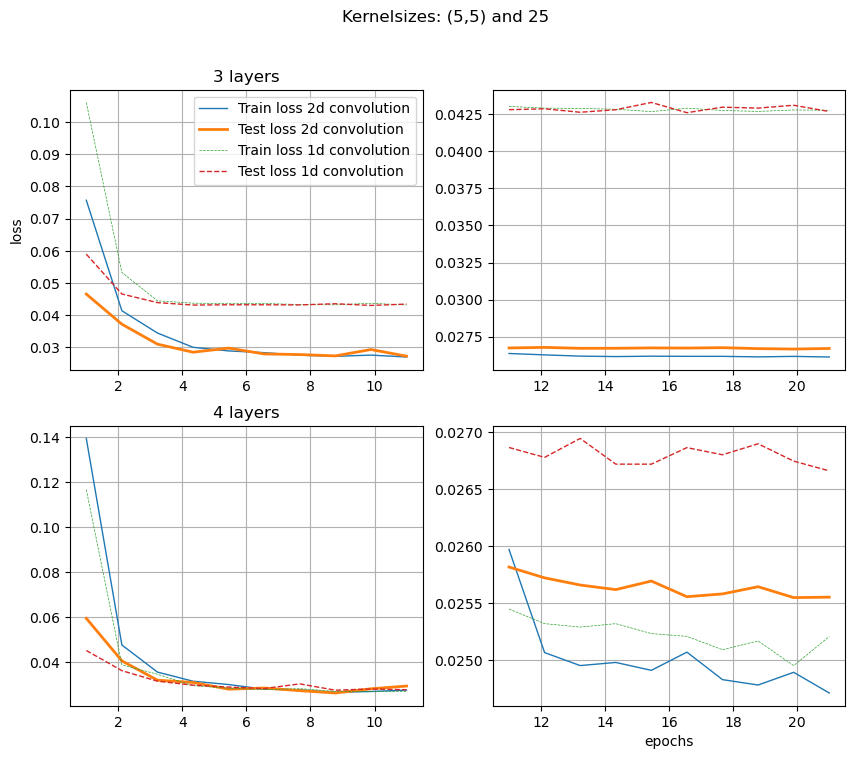

In [54]:
start = 0
end = 10
start1 = 10
end1 = 20

flat_train = np.load('data/example_3_2/train_loss_cnn_1d_25k.npy')
flat_test = np.load('data/example_3_2/test_loss_cnn_1d_25k.npy')
img_train = np.load('data/example_3_2/train_loss_cnn_2d_25k.npy')
img_test = np.load('data/example_3_2/test_loss_cnn_2d_25k.npy')

flat_train_3l = np.load('data/example_3_2/train_loss_cnn_1d_3layers_25k.npy')
flat_test_3l = np.load('data/example_3_2/test_loss_cnn_1d_3layers_25k.npy')
img_train_3l = np.load('data/example_3_2/train_loss_cnn_2d_3layers_25k.npy')
img_test_3l = np.load('data/example_3_2/test_loss_cnn_2d_3layers_25k.npy')

x= np.linspace(start+1,end+1,len(img_train[start:end]))#
x1 = np.linspace(start1+1,end1+1, len(img_train[start+1:end+1]))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=False, sharex=False)

ax1.plot(x, img_train_3l[start:end],label='Train loss 2d convolution', linestyle='-', linewidth=1)
ax1.plot(x, img_test_3l[start:end],label='Test loss 2d convolution', linestyle='-', linewidth=2)
ax1.plot(x, flat_train_3l[start:end],label='Train loss 1d convolution', linestyle='--', linewidth=0.5)
ax1.plot(x, flat_test_3l[start:end],label='Test loss 1d convolution', linestyle='--', linewidth=1)

ax2.plot(x1, img_train_3l[start1:end1],label='Train loss 2d convolution', linestyle='-', linewidth=1)
ax2.plot(x1, img_test_3l[start1:end1],label='Test loss 2d convolution', linestyle='-', linewidth=2)
ax2.plot(x1, flat_train_3l[start1:end1],label='Train loss 1d convolution', linestyle='--', linewidth=0.5)
ax2.plot(x1, flat_test_3l[start1:end1],label='Test loss 1d convolution', linestyle='--', linewidth=1)

ax3.plot(x, img_train[start:end],label='Train loss 2d convolution', linestyle='-', linewidth=1)
ax3.plot(x, img_test[start:end],label='Test loss 2d convolution', linestyle='-', linewidth=2)
ax3.plot(x, flat_train[start:end],label='Train loss 1d convolution', linestyle='--', linewidth=0.5)
ax3.plot(x, flat_test[start:end],label='Test loss 1d convolution', linestyle='--', linewidth=1)

ax4.plot(x1, img_train[start1:end1],label='Train loss 2d convolution', linestyle='-', linewidth=1)
ax4.plot(x1, img_test[start1:end1],label='Test loss 2d convolution', linestyle='-', linewidth=2)
ax4.plot(x1, flat_train[start1:end1],label='Train loss 1d convolution', linestyle='--', linewidth=0.5)
ax4.plot(x1, flat_test[start1:end1],label='Test loss 1d convolution', linestyle='--', linewidth=1)

fig.suptitle('Kernelsizes: (5,5) and 25')
fig.set_size_inches(10,8)
ax4.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_title('3 layers')
ax3.set_title('4 layers')
ax1.legend()
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)
plt.savefig('example_3_2_loss_values_large_kernel.png')
plt.show()